### Start with Google colab model, which works, and incrementally convert it into what we want

In [2]:
#Predict airlines passengers trend

!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2023-02-08 15:43:34--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv.4’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2023-02-08 15:43:34 (11.9 MB/s) - ‘airline-passengers.csv.4’ saved [2180/2180]



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

Test! We need "proper" cross entropy loss functions that can compare two distributions, this feature is not available in all versions of PyTorch. If the code below does works, then PyTorch meets our minimal requirements:

In [ ]:
loss = nn.CrossEntropyLoss()

input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)

(144, 1)


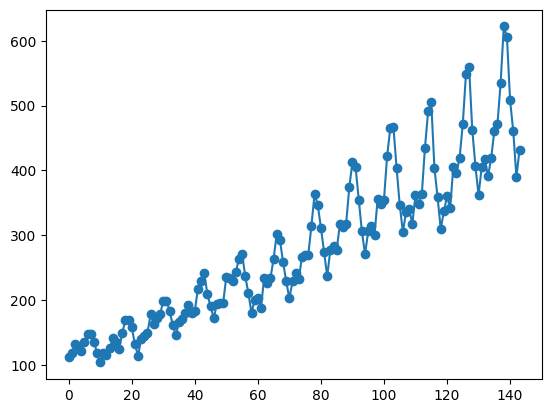

In [3]:
training_set = pd.read_csv('airline-passengers.csv')
training_set = training_set.iloc[:,1:2].values
print (np.shape(training_set))
plt.plot(training_set, 'o-', label = 'Airline Passangers Data')
plt.show()

### First Step: We create a integer index from the real valued data. The index will have a size vocab 

The data is real spaced and lies between a( = x_min) and b ( = xmax). The index we will create is a set of integers between zero and vocab (including 0, excluding voab). If a data point is given by y and the corresponding index is given by x, then the mapping is linear: y-a = (x-0)*(b-a)/(vocab-1). Or, 
x = (y-a)*(vocab-1)/(b-1). This produces a real values x. We get the index by taking floor(x). 

In [4]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 16
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.80)
test_size = len(y) - train_size

dataX = torch.Tensor(np.array(x))
dataY = torch.Tensor(np.array(y))

trainX = torch.Tensor(np.array(x[0:train_size]))
trainY = torch.Tensor(np.array(y[0:train_size]))

testX = torch.Tensor(np.array(x[train_size:len(x)]))
testY = torch.Tensor(np.array(y[train_size:len(y)]))

In [834]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, dev):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        # self.sm = nn.Softmax(dim=1)

        self.device = dev
        self.lstm.to(dev)
        self.fc.to(dev)
        # self.sm.to(dev)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size
        ).to(self.device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size
        ).to(self.device))
        
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        # pout = self.sm(out)
        
        return out

In [319]:
num_epochs = 10000
# learning_rate = 0.015
learning_rate = 1e-6

input_size = 1
hidden_size = 128
num_layers = 1

#num_classes = 1
num_classes = 2048

In [320]:
trainY.shape

torch.Size([85, 1])

These functions help in mapping training values (Y-values) onto probability distributions (represented using histograms). The names of these are a work in progress.

In [ ]:
def get_minmax(data):
    """
        get_minmax(data)
    Returns the min and max of `data`
    """
    return torch.min(data), torch.max(data)

def generate_distribution(y, a, b, n, sigma):
    """
        generate_distribution(y, a, b, n, sigma)
    Returns a histogram of `n` bins between `a` and `b` whose weights are
    distributed according to a Gaussian probability density with mean `y` and
    standard deviation `sigma`
    """
    dx  = (b - a) / (n - 1)
    idx = torch.arange(n)
    x   = a + idx*dx
    return 1/(np.sqrt(2*np.pi)*sigma)*torch.exp(-((x-y)/sigma)**2)

def target_distribution(data, a, b, n, sigma):
    """
        target_distribution(data, a, b, n, sigma)
    Take target training data (y-values) in `data` and replace each row with a
    histogram consisting of `n` bins between `a` and `b` with probabilities
    distributed by a Gaussian probability density centered at the y-values from
    each row of `data` and with a standard deviation of `sigma`
    """
    dist = generate_distribution(data[1], a, b, n, sigma)
    dist.unsqueeze_(0)

    for r in data[1:]:
        R = generate_distribution(r, a, b, n, sigma)
        R.unsqueeze_(0)

        dist = torch.concatenate(
            (dist, R),
            dim = 0
        )
    return dist

In [322]:
a, b = get_minmax(dataY)

In [330]:
trainY.shape

torch.Size([85, 1])

Lets demonstrate the distribution functions in action

In [328]:
dist_trainY = target_distribution(trainY, a, b, num_classes, 0.01)

In [332]:
dist_trainY.shape

torch.Size([85, 2048])

Here is an example where the y-training values are replaced by Gaussian probabilities

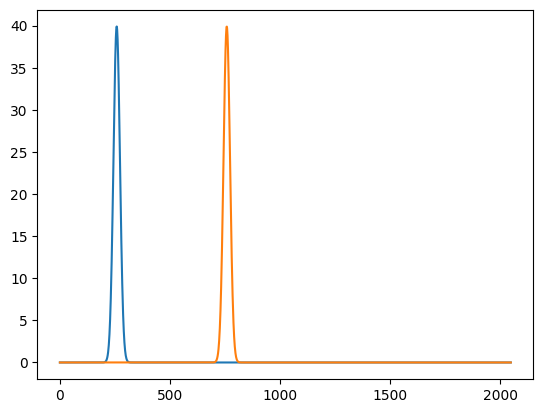

In [333]:
plt.plot(dist_trainY[10,:])
plt.plot(dist_trainY[50,:])

Now we generate synthetic data by taking the existing training data and perturbing it with Gaussian random noise (with zero mean and standard deviation $\sigma$). We then broaden the distribution around the training target ($y$-values) by the same $\sigma$. This process is repeated using increasing values of $\sigma$. The objective is to "show" the neural network how noisy data "looks", and that is should output a broader distribution whenever it encounters noisy data.

In [334]:
synth_trainY = dist_trainY.clone()
synth_trainX =      trainX.clone()

In [335]:
for sigma in np.arange(0.01, 0.2, 0.01):
    print(f"{sigma:0.6f}", end="\r")
    
    w = torch.randn(trainX.shape)*sigma

    synth_trainX = torch.concatenate(
        (synth_trainX, trainX + w),
        dim = 0
    )

    dist_trainY = target_distribution(trainY, a, b, num_classes, 0.01 + sigma)

    synth_trainY = torch.concatenate(
        (synth_trainY, dist_trainY),
        dim = 0
    )

In [336]:
synth_trainX.shape

torch.Size([1700, 16, 1])

In [337]:
synth_trainY.shape

torch.Size([1700, 2048])

Send data to device and train

In [338]:
device = torch.device("cuda:0")
synth_trainX = synth_trainX.to(device)
synth_trainY = synth_trainY.to(device)

In [339]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers, device)

criterion = nn.CrossEntropyLoss()
losses = list()

In [340]:
num_epochs    = int(2e4)
# optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate, momentum=1e-4, weight_decay=1e-4)
optimizer = torch.optim.Adam(lstm.parameters())


# Train the model
for epoch in range(num_epochs):
    outputs = lstm(synth_trainX)
    loss = criterion(outputs, synth_trainY)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.8f" % (epoch, loss.item()), end="\r")
    losses.append(loss.item())

In [341]:
learning_rate = 1e-5
num_epochs    = int(2e4)
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(synth_trainX)
    loss = criterion(outputs, synth_trainY)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.8f" % (epoch, loss.item()), end="\r")
    losses.append(loss.item())

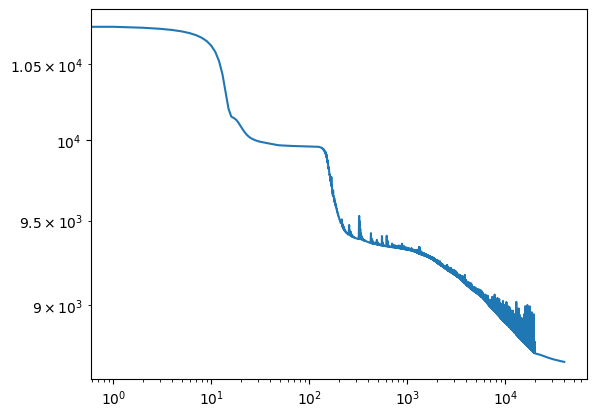

In [342]:
plt.loglog(losses)

In [343]:
# lstm.eval()

In [344]:
m = nn.Softmax(dim=1)
predict = m(lstm(dataX.to(device))).cpu().detach().numpy()

What we see is that if the neural network hasn't seen the inputs, it outputs a broader distribution

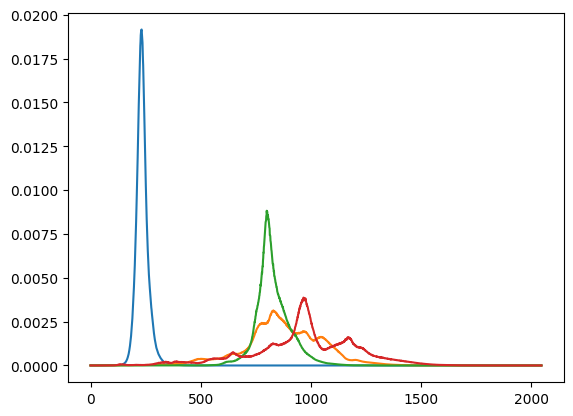

In [345]:
plt.plot(predict[20,:])
plt.plot(predict[90,:])
plt.plot(predict[92,:])
plt.plot(predict[120,:])

In [ ]:
def dist_stats(data, a, b):
    """
        dist_stats(data, a, b)
    Returns the mean and standard deviation for a histogram between `a` and `b`
    """
    n    = len(data)
    dx   = ((b - a) / n).numpy()
    idx  = np.arange(n)
    x    = idx * dx + a.numpy()
    mean = np.sum(x * data)
    return mean, np.sum((x -  mean)**2*data)

In [347]:
xt = list()
vt = list()
for i in range(predict.shape[0]):
    m, e = dist_stats(predict[i, :], a, b)
    xt.append(m)
    vt.append(e)

In [348]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

Here is an example of how the predicted distributions standard deviation can be used to indicate low certainty in the prediction whenever the neural network hasn't "seen" the inputs before.

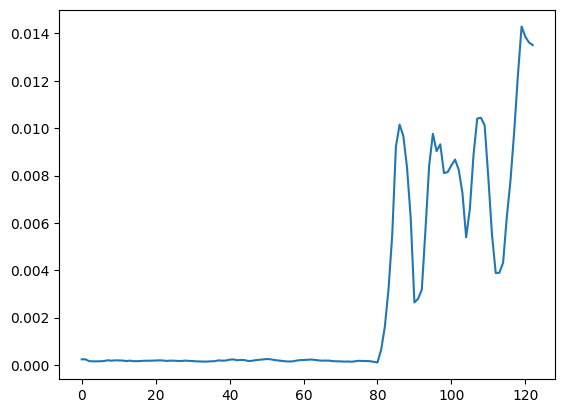

In [349]:
plt.plot(moving_average(vt, n=5))

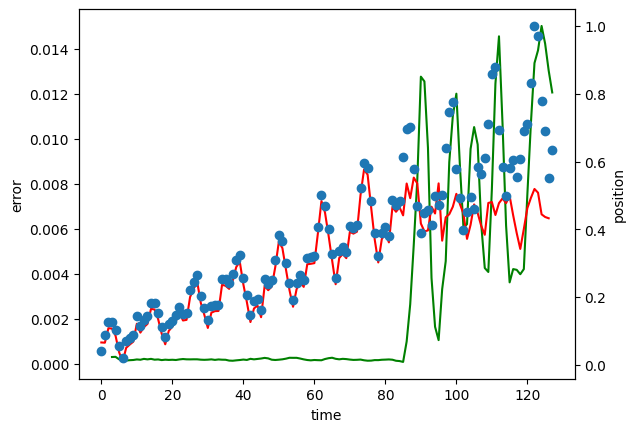

In [350]:
n_avg  = 3
vt_avg = moving_average(vt, n=n_avg)
plt.plot(range(n_avg, n_avg + len(vt_avg)), vt_avg, 'g')
plt.xlabel("time")
plt.ylabel("error")
plt.twinx()
plt.plot(xt, color='r')
plt.ylabel("position")

plt.plot(training_data[16:], 'o')

In [189]:
m = nn.Softmax(dim=1)
predict = lambda x: m(
    lstm(x.to(device)).cpu()
).detach().numpy()

In [ ]:
def shuffle(data, new):
    """
        shuffle(data, new)
    Adds `new` to the end of `data`, moving the entries of `data` back by one
    position, and dropping the value at `data[0]`
    """
    n = data.shape[1]
    A = data.clone()
    B = data.clone()
    A[0, :n-1, 0] = B[0, 1:, 0]
    A[0, n-1, 0] = new
    return A.clone()

def sample(data, a, b):
    """
        sample(data, a, b)
    Returns a random sample between `a`, and `b` using the probabilities given
    in `data`
    """
    return np.random.choice(
        np.arange(a, b, (b-a)/data.shape[1]), 1, p=data[0,:]
    )

In [309]:
X = trainX[20].to(device).unsqueeze(0).clone()

In [310]:
X

tensor([[[0.1042],
         [0.0560],
         [0.0193],
         [0.0695],
         [0.0792],
         [0.0888],
         [0.1429],
         [0.1139],
         [0.1313],
         [0.1429],
         [0.1834],
         [0.1834],
         [0.1544],
         [0.1120],
         [0.0811],
         [0.1197]]], device='cuda:0')

In [311]:
predict(X)

array([[6.1931712e-07, 6.2250524e-07, 6.6705434e-07, ..., 5.8653733e-16,
        6.2479104e-16, 7.3120045e-16]], dtype=float32)

In [312]:
xt = []
et = []

for i in range(20):
    Y = predict(X)
    x, e = dist_stats(Y[0, :], a, b)
    X = shuffle(X, x)
    xt.append(x)
    et.append(e)
    
xt = np.array(xt)
et = np.array(et)

## MD Langevin

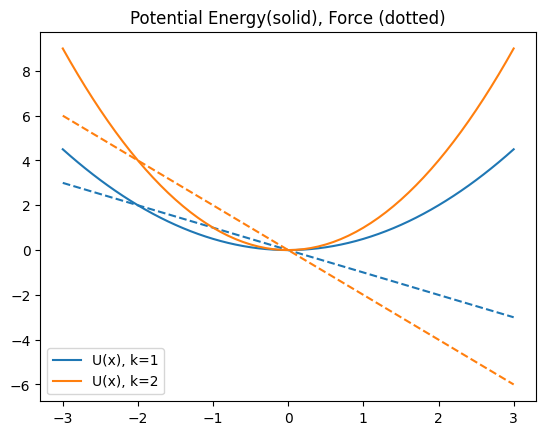

In [314]:
#this function returns the energy and force on a particle from a harmonic potential
def harmonic_oscillator_energy_force(x,k=1,x0=0):
    energy = 0.5*k*(x-x0)**2
    force = -k*(x-x0)
    return energy, force

#this function will plot the energy and force
#it is very general since it uses a special python trick of taking arbitrary named arguments (**kwargs) 
#and passes them on to a specified input function
def plot_energy_force(function, xmin=-3,xmax=3,spacing=0.1,**kwargs):
    x_points = np.arange(xmin,xmax+spacing,spacing)
    energies, forces = function(x_points,**kwargs)
    label = 'U(x)'
    for arg in kwargs:
        label=label+', %s=%s'%(arg,str(kwargs[arg]))
        p = plt.plot(x_points,energies,label=label)
        plt.plot(x_points,forces,label='',color=p[0].get_color(),linestyle='--')
        plt.legend(loc=0)
        plt.title("Potential Energy(solid), Force (dotted)")
        plt.savefig(str(function)+".png")
        
#we can plot the energy (solid) and forces (dashed) to see if it looks right
plot_energy_force(harmonic_oscillator_energy_force,k=1)
plot_energy_force(harmonic_oscillator_energy_force,k=2)

In [315]:
#this is step A
def position_update(x,v,dt):
    x_new = x + v*dt/2.
    return x_new


#this is step B
def velocity_update(v,F,dt):
    v_new = v + F*dt/2.
    return v_new

def random_velocity_update(v,gamma,kBT,dt):
    R = np.random.normal()
    c1 = np.exp(-gamma*dt)
    c2 = np.sqrt(1-c1*c1)*np.sqrt(kBT)
    v_new = c1*v + R*c2
    return v_new

def baoab(potential, max_time, dt, gamma, kBT, initial_position, initial_velocity,
                                        save_frequency=3, **kwargs ):
    x = initial_position
    v = initial_velocity
    t = 0
    step_number = 0
    positions = []
    velocities = []
    total_energies = []
    save_times = []
    
    while(t<max_time):
        # B
        potential_energy, force = potential(x,**kwargs)
        v = velocity_update(v,force,dt)
        # A
        x = position_update(x,v,dt)
        # O
        v = random_velocity_update(v,gamma,kBT,dt)
        # A
        x = position_update(x,v,dt)
        # B
        potential_energy, force = potential(x,**kwargs)
        v = velocity_update(v,force,dt)
        
        if step_number%save_frequency == 0 and step_number>0:
            e_total = .5*v*v + potential_energy

            positions.append(x)
            velocities.append(v)
            total_energies.append(e_total)
            save_times.append(t)
        
        t = t+dt
        step_number = step_number + 1
    
    return save_times, positions, velocities, total_energies   

(13333,)
(13333, 1)


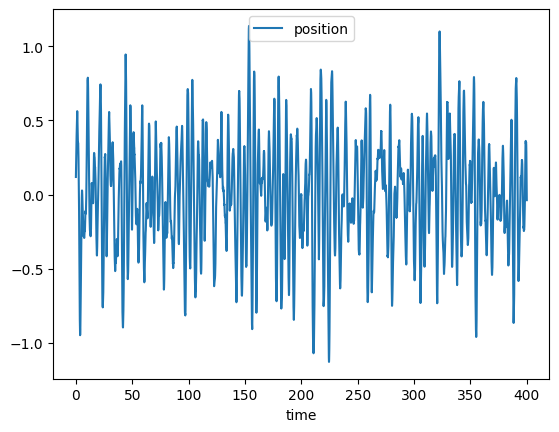

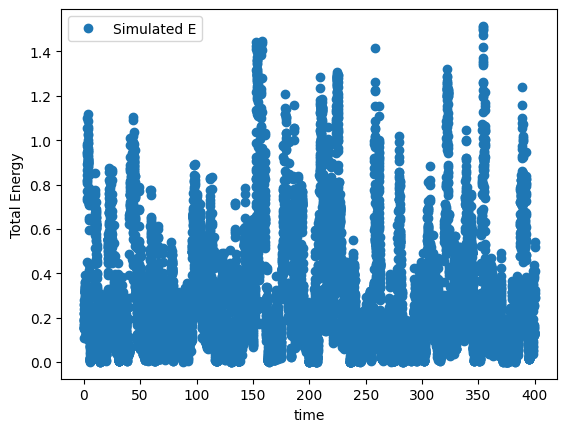

In [699]:
my_k = 2
my_max_time = 400
initial_position = .1
initial_velocity = .5

my_gamma=0.5
my_kBT=0.25
my_dt=0.01

times, positions, velocities, total_energies = baoab(
    harmonic_oscillator_energy_force,
    my_max_time, my_dt, my_gamma, my_kBT,
    initial_position, initial_velocity,
    k=my_k
)

plt.plot(times, positions, marker='', label='position', linestyle='-')

plt.xlabel('time')
plt.legend(loc='upper center')
plt.savefig("harm-v-x.png")
plt.figure()
plt.plot(times, total_energies, marker='o', linestyle='', label='Simulated E')
plt.xlabel('time')
plt.ylabel("Total Energy")
plt.legend()
plt.savefig("harm-e.png")

positions = np.array(positions)
print (np.shape(positions))

training_set = positions.reshape(positions.shape + (1,))
print (np.shape(training_set))

In [721]:
seq_length = 8
x, y = sliding_windows(training_set, seq_length)

train_size = int(len(y) * 1.00)
test_size = len(y) - train_size

dataX = torch.Tensor(np.array(x))
dataY = torch.Tensor(np.array(y))

trainX = torch.Tensor(np.array(x[0:train_size]))
trainY = torch.Tensor(np.array(y[0:train_size]))

testX = torch.Tensor(np.array(x[train_size:len(x)]))
testY = torch.Tensor(np.array(y[train_size:len(y)]))

In [722]:
a, b = get_minmax(dataY)

In [723]:
trainY.shape

torch.Size([13324, 1])

In [724]:
dist_trainY = target_distribution(trainY, a, b, num_classes, 0.001)

In [725]:
dist_trainY.shape

torch.Size([13324, 2048])

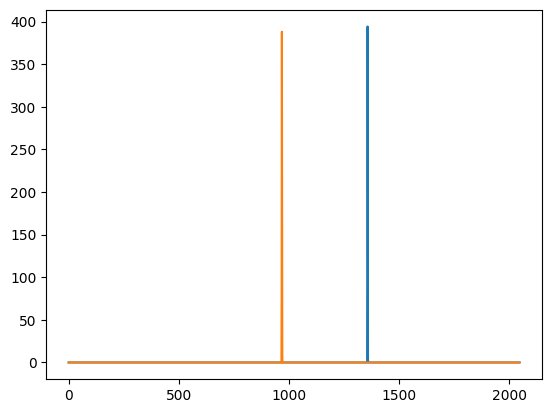

In [727]:
plt.plot(dist_trainY[10,:])
plt.plot(dist_trainY[500,:])

In [728]:
synth_trainY = dist_trainY.clone()
synth_trainX =      trainX.clone()

In [729]:
for sigma in np.arange(0.001, 0.002, 0.0005):
    print(f"{sigma:0.6f}", end="\r")
    
    w = torch.randn(trainX.shape)*sigma

    synth_trainX = torch.concatenate(
        (synth_trainX, trainX + w),
        dim = 0
    )

    dist_trainY = target_distribution(trainY, a, b, num_classes, 0.01 + sigma)

    synth_trainY = torch.concatenate(
        (synth_trainY, dist_trainY),
        dim = 0
    )

In [730]:
device = torch.device("cuda:0")
synth_trainX = synth_trainX.to(device)
synth_trainY = synth_trainY.to(device)

In [831]:
lstm = LSTM(num_classes, input_size, 64, num_layers, device)

criterion = nn.CrossEntropyLoss()
losses = list()

In [ ]:
num_epochs    = int(2e4)
# optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate, momentum=1e-4, weight_decay=1e-4)
optimizer = torch.optim.SGD(lstm.parameters(), lr=1e-4)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(synth_trainX)
    loss = criterion(outputs, synth_trainY)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch: {epoch}, loss: {loss.item():1.8f}", end="\r")
    losses.append(loss.item())

KeyboardInterrupt: 

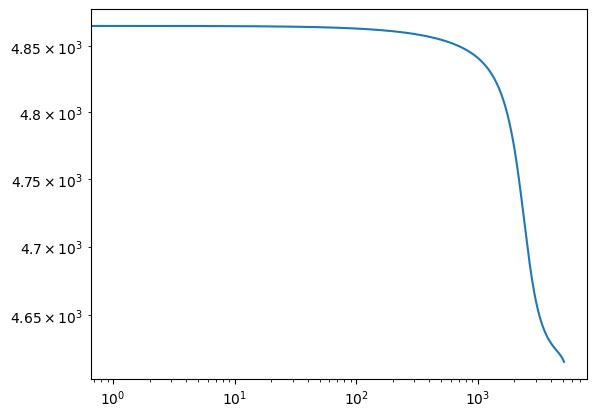

In [820]:
plt.loglog(losses)

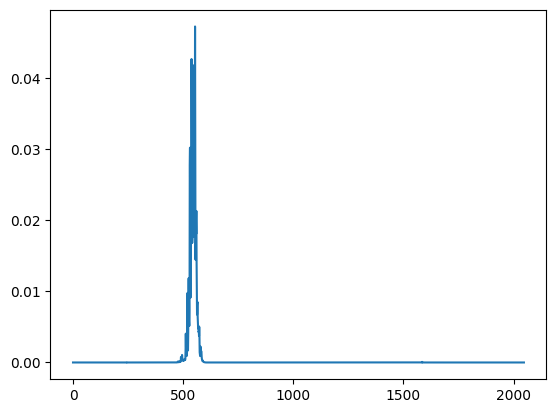

In [821]:
Y = predict(X)
plt.plot(Y[0,:])

In [822]:
m = nn.Softmax(dim=1)
predict = lambda x: m(
    lstm(x.to(device)).cpu()
).detach().numpy()

In [823]:
def shuffle(data, new):
    n = data.shape[1]
    A = data.clone()
    B = data.clone()
    A[0, :n-1, 0] = B[0, 1:, 0]
    A[0, n-1, 0] = new
    return A.clone()

In [824]:
idx = 100

In [825]:
X = trainX[idx].to(device).unsqueeze(0).clone()

Here is an example of how to use the neural network's prediction to generate a trajectory

In [826]:
xt = []
et = []

for i in range(40):
    Y = predict(X)
    x, e = dist_stats(Y[0, :], a, b)
    xs = sample(Y, a, b)[0]
    X = shuffle(X, x)
    xt.append(x)
    et.append(e)
    
xt = np.array(xt)
et = np.array(et)

In [827]:
X

tensor([[[-0.6274],
         [-0.8719],
         [-0.8867],
         [-0.4957],
         [-0.7985],
         [-1.0024],
         [-1.0131],
         [-0.5979]]], device='cuda:0')

Doesn't really work all that well :(

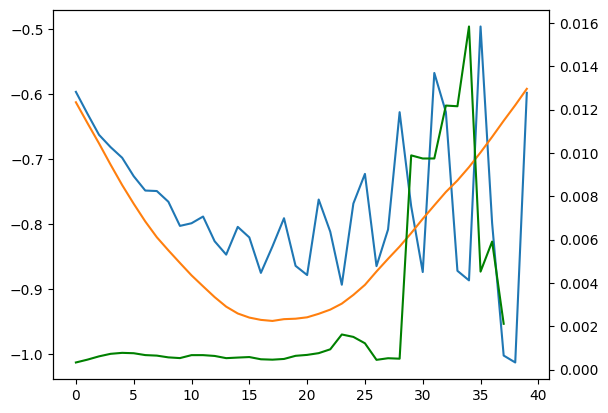

In [828]:
plt.plot(xt)
plt.plot(training_set[idx+8:idx+8+40, 0])
plt.twinx()
plt.plot(moving_average(et, n=3), 'g')